TRABAJO PRACTICO - Integrador: GRUPO 8
#Autores:

- Choconi Lucas
- Berra Eliel
- Mina Federico
- Scillato German

## Importaciones y configuración

Modulos necesarios
- selenium
- webdriver-manager
- bs4
- xgboost

#### Importaciones

In [148]:

import pandas as pd
from sklearn.model_selection import train_test_split
import os
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from lime.lime_tabular import LimeTabularExplainer
import requests
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time


import re
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import pickle


import warnings
warnings.filterwarnings('ignore')
# Cuando se pasa un callable como argumento para modificar el comportamiento predeterminado de alguna etapa
# del preprocesamiento del texto del CountVectorizer se emite un warning. Por lo que investigamos a las
# stopwords que se pasen como argumento se les va a aplicar la misma función que se pasa como callable para
# pre procesarlas.

#### Configuración Gráficos y Path

In [202]:
# Configuración Graficos 


myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)

# Fuente de titulos de gráficos
font = {'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

# Función para graficos de WorldCloud

def blue_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    """Argumentos de función necesarias para metodo worldcloud"""
    blues = "hsl(215,100%%, %d%%)" % np.random.choice(np.arange(25, 65, 5, dtype=int))
    reds = "hsl(0,100%%, %d%%)" % np.random.choice(np.arange(40, 80, 5, dtype=int))
    choice = np.random.choice([0, 1])
    if choice == 0:
        return blues
    else:
        return reds


def graficos_manos(fake,true):
    """Función para graficar worldcloud en forma de manos,
    falsas y verdaderas. Variables: worldcloud falsa y verdadera"""
    fig, axs = plt.subplots(1, 2,figsize=(20,10))  

    axs[1].imshow(fake.recolor(color_func=blue_color_func, random_state=3),
                interpolation="bilinear")
    axs[1].axis("off")
    axs[1].set_title('FAKE' , fontdict = font)
    axs[0].imshow(true.recolor(color_func=blue_color_func,random_state=3),
                interpolation="bilinear")
    axs[0].axis("off")
    axs[0].set_title('TRUE' , fontdict = font)
    plt.show()


In [192]:
# Importación de imagenes para graficos de manos.

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask_pos = np.array(Image.open(path.join(d, "./data/Thumbs.png")))
mask_neg = np.array(Image.open(path.join(d, "./data/Thumbsdw.png")))


## LOGICA DE DESARROLLO DEL MODELO

![Diagrama](./data/fake_d.png)

## Limpieza de datos

In [10]:
# Dataset from https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
file_names_true = pd.read_csv('./data/True.csv')
file_names_true['real'] = 'True'
file_names_fake = pd.read_csv('./data/Fake.csv')
file_names_fake['real'] = 'Fake'
data = file_names_fake.append(file_names_true, ignore_index=True)
data.head(1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9132\636282420.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = file_names_fake.append(file_names_true, ignore_index=True)


,title,text,subject,date,real
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake


In [11]:
# Trabar 1ero con texto y después con el título

In [12]:
# Unimos el título y el contenido del artículo en una sola columna
data['text'] = data['title'] + ' --- ' + data['text'] 

# Porque con with?????? 

with pd.option_context('display.max_colwidth', None):
  print(data.head(1))
data = data.drop(columns = 'title')

                                                                             title  \
0   Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [13]:
# Algunas filas contienen datos erróneos que impiden transformar la columna 'date' a formato fecha
wrong_row = data['date'] == 'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/'
data[wrong_row]

,text,subject,date,real
9358,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,Fake


In [14]:
# Las filas que no pueden ser correctamente transformadas a datetime serán utilizadas en una máscara booleana
# para poder eliminarlas
data['date'] = data['date'].apply(lambda x: pd.to_datetime(x, infer_datetime_format = True)\
                                                           if re.search('[a-z-A-Z]+ [0-9]+, [0-9]{4}', x) else
                                                            np.NaN)
delete_mask = data['date'].notna()
data = data[delete_mask]
data = data.reset_index()
data['date'] = data['date'].astype('datetime64')

In [15]:
# Separamos los datos en las filas que contienen noticias falsas de las que son reales
data_real = data[data['real'] == 'True']

data_fake = data[data['real'] == 'Fake']

In [191]:
# Averiguamos cuál es el largo promedio de las noticias falsas y de las reales y hacemos un gráfico comparativo
######################################## VERRRRR

data['text_len'] = data['text'].apply(lambda x: len(word_tokenize(x)))
real_len_avg = data_real['text_len'].mean()
fake_len_avg = data_fake['text_len'].mean()
len_avgs = [real_len_avg, fake_len_avg]
plt.bar(['Real', 'Fake'], len_avgs)

TypeError: 'module' object is not subscriptable

In [17]:
'''
# Lista con todas las palabras en inglés https://github.com/dwyl/english-words/blob/master/words.txt
all_eng_words = pd.read_csv('./data/all_english_words.csv')
all_eng_words = pd.Series(all_eng_words.iloc[:,0])
all_eng_words = all_eng_words.apply(lambda x: x.lower() if type(x) == str else x)

def words_percentage(text):
    # Devuelve el porcentaje de palabras que posee un texto que están dentro de un diccionario
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words] 
    words_in_dict = [word for word in words if word in all_eng_words.values]
    words_in_dict_percentage = len(words_in_dict) * 100 / len(words)
    return words_in_dict_percentage

tqdm.pandas()
data['words_in_dict_pct'] = data['text'].progress_apply(words_percentage)
'''
'''Esta celda demora 35hs en ejecutarse.'''

'Esta celda demora 35hs en ejecutarse.'

In [164]:
sns.set(rc={'figure.figsize':(15, 4)})
sns.histplot(data = data, x = 'subject', hue = 'real')


################### Acomodar GRAFICO, eje x.

ValueError: Could not interpret value `subject` for parameter `x`

In [19]:
# Como hay valores diferentes en la columna "subject" para las noticias reales y las falsas borramos esa columna
data = data.drop(columns = 'subject')

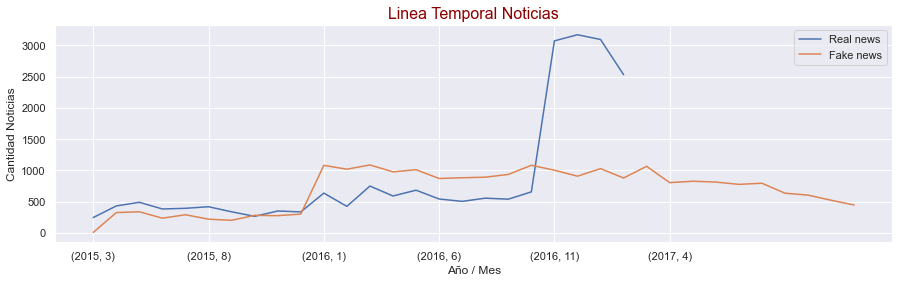

In [194]:
# Hacemos un gráfico mostrando el conteo de cuántas noticias falsas y cuántas verdaderas se publicaron 
# por mes en el dataset 
ax = data_real['date'].groupby([data_real["date"].dt.year,
                             data_real["date"].dt.month]).count().plot.line(label = 'Real news')

ax = data_fake['date'].groupby([data_fake["date"].dt.year,
                            data_fake["date"].dt.month]).count().plot.line(label = 'Fake news')
ax.set(xlabel=None)
ax.set_title('Linea Temporal Noticias' , fontdict = font)
ax.set_xlabel('Año / Mes')
ax.set_ylabel('Cantidad Noticias')
ax.legend()



El pico de noticias verdaderas publicadas en Noviembre del 2016 coincide con las elecciones presidenciales de Estados Unidos

In [21]:
# El dataset no valores nulos así que damos por finalizada la limpieza
data.isna().sum()

index    0
text     0
date     0
real     0
dtype: int64

# Pre-procesamiento

In [198]:
stopwords_en = stopwords.words('english')

wordcloud_fake = WordCloud(stopwords=stopwords_en,
            mask=mask_neg, 
            max_words=500,
            background_color="white").generate(data[data['real']=='Fake'].text.str.cat(sep=' '))
wordcloud_true = WordCloud(stopwords=stopwords_en,
            mask=mask_pos,
            max_words=500,
            background_color="white").generate(data[data['real']=='True'].text.str.cat(sep=' '))


graficos_manos(fake = wordcloud_fake,true = wordcloud_true)

TypeError: 'module' object is not subscriptable

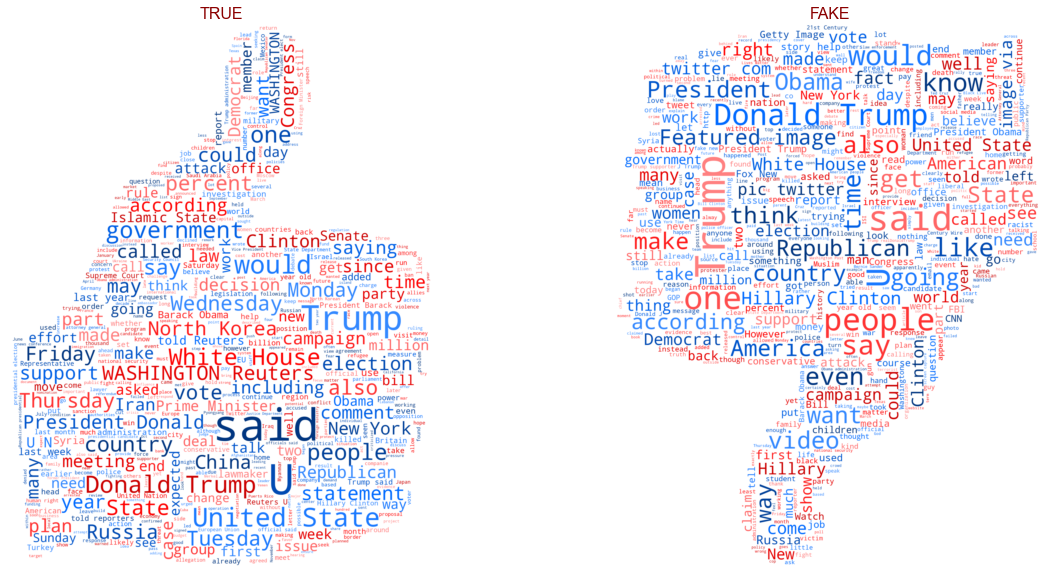

In [196]:
fig, axs = plt.subplots(1, 2,figsize=(20,10))  

axs[1].imshow(wordcloud_fake.recolor(color_func=blue_color_func, random_state=3),
            interpolation="bilinear")
axs[1].axis("off")
axs[1].set_title('FAKE' , fontdict = font)
axs[0].imshow(wordcloud_true.recolor(color_func=blue_color_func,random_state=3),
            interpolation="bilinear")
axs[0].axis("off")
axs[0].set_title('TRUE' , fontdict = font)
plt.show()

In [24]:
testing_sample_size = 2000 # Algunas operaciones se demoran mucho tiempo, tamaño pequeño es para agilizarlas

data_sample = data.sample(testing_sample_size)
X = data_sample['text']
y = data_sample['real']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [25]:
porter = PorterStemmer()
stopwords_en_porter = [porter.stem(x) for x in stopwords_en]


In [26]:
# Agrego Stopwords específicas del dataset.
def append_stopword(listado_stopwords, stopwords_agregar):
    for stopwords in stopwords_agregar:
        listado_stopwords.append(stopwords)
    return listado_stopwords

stopwords_agregar = ['reuter','said','Reuters','via','imag','https','com','one',
'u','also','would','featur','pic','us','wednesday','friday','monday','tuesday',
'saturday','sunday','thursday','getti','read','gop','watch','donald','trump',
'hillari','mr','accord','america','seem','youtub','21st',
'video' , 'http' , 'like' , 'obama' , 'minist' , 'washington' , 'know' , ]

stopwords_en_porter = append_stopword(stopwords_en_porter ,stopwords_agregar )

In [27]:
def porter_tokenizer(text):
    ''' Esta función se utiliza cuando se sobre escribe el proceso
    de tokenización en la clase CountVectorizer para que se pueda
     obtener también la raíz de la palabra.'''
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words]  # remover los caracteres especiales
    words = [word.replace(' ', '') for word in words] #remover los espacios en blanco
    words = [word for word in words if word != '']
    words = [PorterStemmer().stem(word) for word in words] # obtener la raiz de las palabras
    words = [word for word in words if word not in stopwords_en_porter] # remover las stopwords
    return words

In [29]:
# Esta celda se demora un poco en ejecutarse
# La ventaja de este CountVectorizer customizado es que permite obtener la raíz de la palabra
customized_vectorizer= CountVectorizer(lowercase = True,
                                        strip_accents='unicode', 
                                        tokenizer = porter_tokenizer,
                                        ngram_range = (1, 3),
                                        min_df = 3)

##### usar fit_transform?????????
customized_vectorizer.fit(X_train)
customized_vectorizer_matrix = customized_vectorizer.transform(X_train)
#customized_vectorizer_df = pd.DataFrame(customized_vectorizer_matrix.todense(),
#                                        columns=customized_vectorizer.get_feature_names())

customized_vectorizer_test = customized_vectorizer.transform(X_test)
#customized_vectorizer_df.head(2)

In [31]:
tfidf_matrix = TfidfTransformer().fit_transform(customized_vectorizer_matrix)
"""tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = customized_vectorizer.get_feature_names())
tfidf_df.head(2)"""
# BUG: agregue fit al transform de la siguiente línea.
tfidf_matrix_test = TfidfTransformer().fit_transform(customized_vectorizer_test) 

#### Cambio de Base: Evaluación del impacto con distintas cantidades de componentes

In [203]:
# Definición de función para cambio de base

def select_n_components(var_ratio, goal_var: float) -> int: 
    ''' Esta función se utiliza para hacer un cambio de base y lograr explicar
    el porcentaje de los datos que se pasa en el argumento goal_var.
    Fuente https://chrisalbon.com/code/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/
    Fue modificada para que hiciera un gráfico de la varianza explicativa del
    modelo de acuerdo al número de componentes'''
    # Set initial variance explained so far
    total_variance = 0.0
    # Set initial number of features
    n_components = 0
    # Listas del nuḿero de componentes y de la explicación de varianza alcanzada para poder graficarlas
    num_components = list(range(1, len(var_ratio) + 1))
    variances = []
    # For the explained variance of each feature:
    found_n_components = False
    for explained_variance in var_ratio:
        # Add the explained variance to the total
        total_variance += explained_variance
        # Add one to the number of components
        n_components += 1
        # Agregar la varianza explicada al listado 
        variances.append(total_variance)
        # If we reach our goal level of explained variance and we haven't reached our desired variance
        if total_variance >= goal_var and found_n_components == False:
            desired_n_components = n_components
            found_n_components = True
            desired_variance = total_variance
    plt.plot(num_components, variances)
    plt.scatter(desired_n_components, desired_variance, c = 'r')
    plt.xlabel('Número de componentes')
    plt.ylabel('Razón de la explicación de la varianza')
    plt.hlines(desired_variance, 0, desired_n_components, 'r', 'dashed')
    plt.vlines(desired_n_components, 0, desired_variance, 'r', 'dashed')
    plt.title("Comparativa Varianza vs Número componentes ",fontdict=font)
        
    # Return the desired number of components. 
    # Tipo de variable devuelta definido por " -> int " PEP3107
    return desired_n_components

Número de componentes después del cambio de base: 1008
Número de componentes después del cambio de base: 315


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Número de componentes después del cambio de base: 23


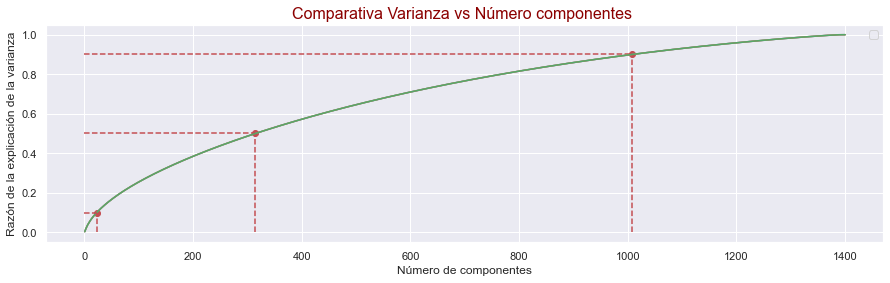

In [206]:
# Evaluación de cambio de base para 3 threshold
# Evaluamos cómo responde el cambio de base cuando seleccionamos una explicación
# de la varianza alta (0.9), media (0.5) o baja (0.1)
desired_threshold = [0.9 , 0.5 , 0.1]

for thres in desired_threshold:
    # Tener en cuenta que si el número de filas de la matrix esparsa es menor al número de componentes elegido
    # como hiperparámetro, una vez que se haya realizado la transformación SVD el número de componentes 
    # obtenido será igual al número de filas de la matriz esparsa, y no será el número de componentes
    # elegido como hiperpárametro
    test_svd = TruncatedSVD(n_components = tfidf_matrix.shape[1] - 1);
    test_svd.fit(tfidf_matrix)
    tsvd_var_ratios = test_svd.explained_variance_ratio_
    desired_threshold = thres
    n_components = select_n_components(tsvd_var_ratios, desired_threshold)

    print(f'Para Threshold {thres}, número de componentes después del cambio de base: {n_components}')

In [36]:
# Esta celda demora en ejecutarse
svd = TruncatedSVD(n_components = n_components)
svd_matrix = svd.fit_transform(tfidf_matrix)
svd_df = pd.DataFrame(svd_matrix)
print(svd_df.head(2))

svd_test = svd.transform(tfidf_matrix_test)

         0         1         2         3         4         5         6   \
0  0.084969  0.085612 -0.011282 -0.026786 -0.039483  0.043567  0.007712   
1  0.119503 -0.023707 -0.061757  0.050432  0.025704 -0.017467 -0.068291   

         7         8         9   ...        13        14        15        16  \
0  0.005128  0.019262  0.047679  ... -0.036093  0.014162  0.050752  0.025253   
1  0.071502 -0.014804  0.032944  ... -0.016145  0.059778 -0.042104 -0.049162   

         17        18        19        20        21        22  
0  0.007048 -0.010338  0.001326  0.001745  0.043715 -0.148422  
1  0.054428 -0.005326  0.073056 -0.079707 -0.050424  0.018234  

[2 rows x 23 columns]


## Feature Selection
Esta etapa de la construcción del modelo, se hizo de forma iterativa, verificando palabras que no tuvieran sentido real en la predicción de noticias falsa

In [ ]:
# Esta celda se demora un poco en ejecutarse
# La ventaja de este CountVectorizer customizado es que permite obtener la raíz de la palabra
customized_vectorizer= CountVectorizer(lowercase = True,
                                        strip_accents='unicode', 
                                        tokenizer = porter_tokenizer,
                                        ngram_range = (1, 3),
                                        min_df = 0.002,
                                        max_df= 0.9)


customized_vectorizer.fit(data.text)
customized_vectorizer_matrix = customized_vectorizer.transform(data.text)


In [ ]:
tfidf_matrix_feature = TfidfTransformer().fit_transform(customized_vectorizer_matrix)

In [ ]:
# Definición de modelo Tree para evaluar peso de cada palabra.
dt = tree.DecisionTreeClassifier(criterion='gini',
max_depth=4,min_samples_leaf=2)
dt.fit(tfidf_matrix, data["real"])
importancia_features = pd.DataFrame(dt.feature_importances_, index = customized_vectorizer.get_feature_names(),
 columns=['importancia'])
importancia_features_sort = importancia_features.sort_values('importancia', ascending=False)
print(importancia_features_sort[0:15])

### Robustez del modelo - Influencia de stopwords

Se detecto que el modelo sobreajuste para el dataset inicial, si no se retira las stopwords definidas. A continuación se muestra los resultados del modelo incluyendo dichas palabras. Se utiliza el modelo de "Tree" como ejemplo.

In [ ]:
# Se redefine x_train y x_test
testing_sample_size = 1000 # Algunas operaciones se demoran mucho tiempo, tamaño pequeño es para agilizarlas

data_sample = data.sample(testing_sample_size)
X = data_sample['text']
y = data_sample['real']
X_train_completo, X_test_completo, y_train_completo, y_test_completo = train_test_split(X, y, test_size = 0.3)

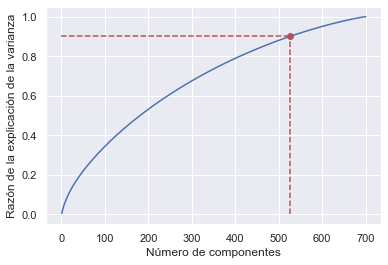

In [ ]:
# Se redefine stopwords y se genera nuevamente la vectorización, y la matriz tfidf


stopwords_en_porter = [porter.stem(x) for x in stopwords_en]
customized_vectorizer= CountVectorizer(lowercase = True,
                                        strip_accents='unicode', 
                                        tokenizer = porter_tokenizer,
                                        ngram_range = (1, 3),
                                        min_df = 3)


customized_vectorizer.fit(X_train_completo)
customized_vectorizer_matrix = customized_vectorizer.transform(X_train_completo)
"""customized_vectorizer_df = pd.DataFrame(customized_vectorizer_matrix.todense(),
                                        columns=customized_vectorizer.get_feature_names())
"""
customized_vectorizer_test = customized_vectorizer.transform(X_test_completo)
"""customized_vectorizer_df.head(2)"""
tfidf_matrix = TfidfTransformer().fit_transform(customized_vectorizer_matrix)
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = customized_vectorizer.get_feature_names())


tfidf_matrix_test = TfidfTransformer().fit_transform(customized_vectorizer_test) 

test_svd = TruncatedSVD(n_components = tfidf_matrix.shape[1] - 1);
test_svd.fit(tfidf_matrix)
tsvd_var_ratios = test_svd.explained_variance_ratio_
desired_threshold = 0.90
n_components = select_n_components(tsvd_var_ratios, desired_threshold)


svd = TruncatedSVD(n_components = n_components)
svd_matrix = svd.fit_transform(tfidf_matrix)
svd_df = pd.DataFrame(svd_matrix)


svd_test = svd.transform(tfidf_matrix_test)
X_train_completo= tfidf_df
X_test_completo = tfidf_matrix_test

In [ ]:

# Modelo ejemplo para mostrar sobre ajuste.
my_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
my_tree.fit(X_train_completo , y_train_completo )
print("Score modelo con stopwords: ", my_tree.score(X_test_completo , y_test_completo ))


Score modelo con stopwords:  0.98


<Figure size 1440x432 with 0 Axes>

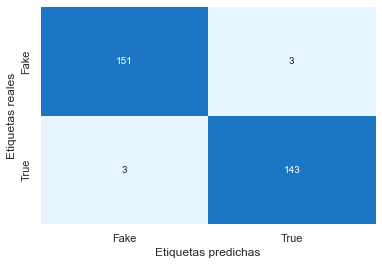

<Figure size 1440x432 with 0 Axes>

In [ ]:
cm_tree = confusion_matrix(y_test_completo , my_tree.predict(X_test_completo ))

axis_labels = np.sort(y_test.unique())
sns.heatmap(cm_tree, xticklabels=axis_labels,yticklabels=axis_labels,
             cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');
plt.figure(figsize=(20,6))

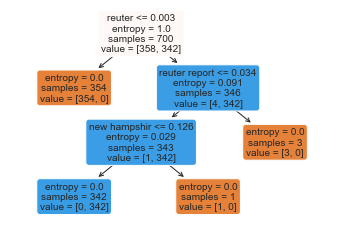

In [ ]:
tree.plot_tree(my_tree,feature_names = X_train_completo .columns,
                filled=True,rounded=True, fontsize = 10)
plt.show()

# Modelos

In [ ]:
X_train = tfidf_matrix
X_test = tfidf_matrix_test

## Naive Bayes

In [38]:
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
NB_model.score(X_test, y_test)

0.93

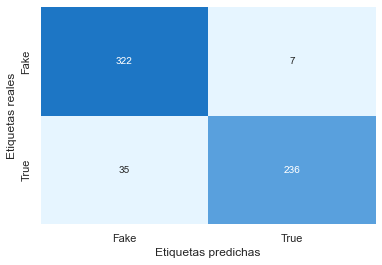

In [39]:

axis_labels = np.sort(y_test.unique())
cm_nb = confusion_matrix(y_test, NB_model.predict(X_test))
sns.heatmap(cm_nb, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

#### Modelo de Reg. Logistica

In [40]:
reg_model = LogisticRegression(C = 7, solver="saga", l1_ratio=0.5 ,
                                 penalty="elasticnet", n_jobs=-1)
reg_model.fit(X_train, y_train)
reg_model.score(X_test, y_test)

0.9516666666666667

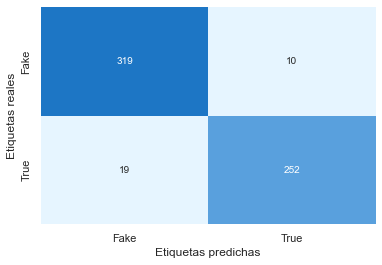

In [41]:
cm_rlog = confusion_matrix(y_test, reg_model.predict(X_test))
sns.heatmap(cm_rlog, xticklabels=axis_labels, yticklabels=axis_labels,
             cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

In [46]:

Coef_reg_model = pd.DataFrame(np.transpose(reg_model.coef_), index=customized_vectorizer.get_feature_names(),
 columns=['Coef'])
Coef_reg_model['coef_abs'] = abs(Coef_reg_model['Coef'])
Coef_reg_model = Coef_reg_model.reset_index(-1)
Coef_reg_model['words'] = Coef_reg_model['index'] 
Coef_reg_model['freq'] = (round(Coef_reg_model['coef_abs'] / Coef_reg_model.coef_abs.sum() * Coef_reg_model.shape[0] * 1000 , 0)).apply(lambda x: int(x))
Coef_reg_model['odds_direction'] = Coef_reg_model['Coef'].apply(lambda x: 'Negative' if x<0 else 'Positive')
Coef_reg_model_positive = Coef_reg_model[Coef_reg_model['odds_direction']=='Positive']
Coef_reg_model_positive = Coef_reg_model_positive.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)
Coef_reg_model_negative = Coef_reg_model[Coef_reg_model['odds_direction']=='Negative']
Coef_reg_model_negative = Coef_reg_model_negative.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)

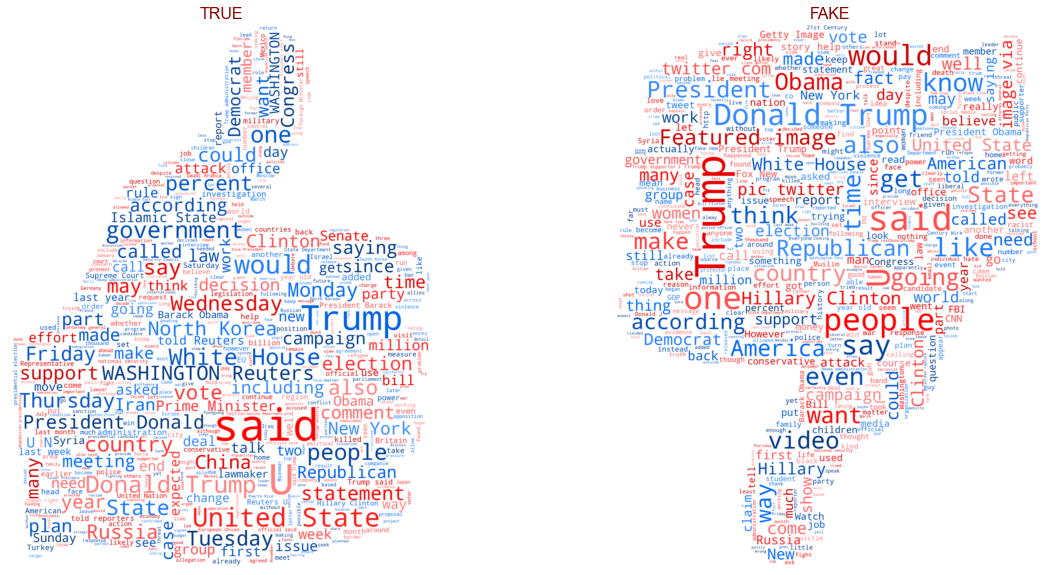

In [201]:
tuples_pos = Coef_reg_model_positive.set_index('words').T.to_dict('index')
tuples_neg = Coef_reg_model_negative.set_index('words').T.to_dict('index')

wordcloud_positive = WordCloud(max_words=500, mask=mask_pos,
        background_color="white").generate_from_frequencies(dict(tuples_pos['freq']))
wordcloud_negative = WordCloud(max_words=500, mask=mask_neg,
        background_color="white").generate_from_frequencies(dict(tuples_neg['freq']))

graficos_manos(fake = wordcloud_fake,true = wordcloud_true)

## Modelo de Reg. Logistica Truncando palabras

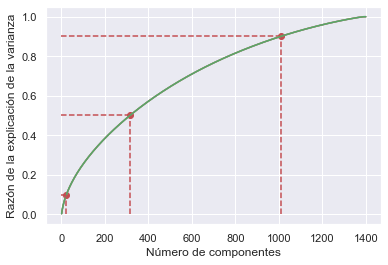

In [50]:
test_svd = TruncatedSVD(n_components = tfidf_matrix.shape[1] - 1);
test_svd.fit(tfidf_matrix)
tsvd_var_ratios = test_svd.explained_variance_ratio_
desired_threshold_90 = 0.90
desired_threshold_50 = 0.50
desired_threshold_10 = 0.10
n_components_90 = select_n_components(tsvd_var_ratios, desired_threshold_90)
n_components_50 = select_n_components(tsvd_var_ratios, desired_threshold_50)
n_components_10 = select_n_components(tsvd_var_ratios, desired_threshold_10)


In [51]:


svd_90 = TruncatedSVD(n_components = n_components_90)
svd_50 = TruncatedSVD(n_components = n_components_50)
svd_10 = TruncatedSVD(n_components = n_components_10)

X_train_svd_90 = svd_90.fit_transform(X_train)
X_test_svd_90 = svd_90.transform(X_test)
X_train_svd_50 = svd_50.fit_transform(X_train)
X_test_svd_50 = svd_50.transform(X_test)
X_train_svd_10 = svd_10.fit_transform(X_train)
X_test_svd_10 = svd_10.transform(X_test)

In [52]:
X_svd = [[X_train_svd_90,X_test_svd_90],[X_train_svd_50,X_test_svd_50],[X_train_svd_10,X_test_svd_10]]
scores = []
models = []
for svd in X_svd:

    reg_model_svd = LogisticRegression(C = 8, solver="newton-cg", penalty="l2")
    models.append(reg_model_svd.fit(svd[0], y_train))
    scores.append(reg_model_svd.score(svd[1], y_test))


    

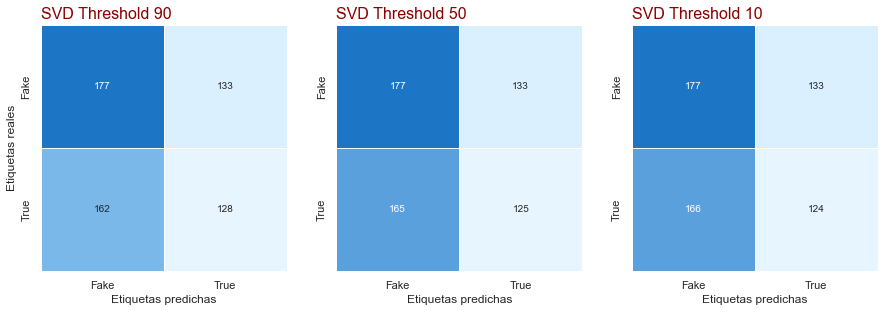

In [136]:
figs, axs = plt.subplots(1,3, figsize= (15,5))
title = [90,50,10]
for i in range(3):
    
    cm_rlog_svd = confusion_matrix(y_test, models[i].predict(X_svd[i][1]))
    sns.heatmap(cm_rlog_svd,xticklabels=axis_labels, yticklabels=axis_labels,
                cbar=False, annot=True, cmap=cmap, fmt='d', ax = axs[i],
                linecolor = "w" , linewidths = .5,square=True)
    axs[i].set_title(label = f'SVD Threshold {title[i]}' , 
    loc ='left', fontdict = font )
    axs[0].set_ylabel('Etiquetas reales')
    axs[i].set_xlabel('Etiquetas predichas')
    

## Decision Tree Classifier

In [67]:
my_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
my_tree.fit(X_train, y_train)
my_tree.score(X_test, y_test)

0.7983333333333333

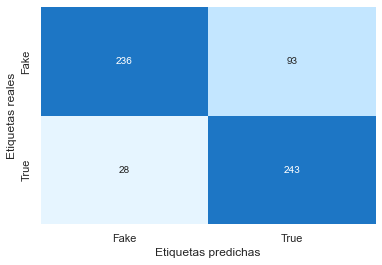

In [68]:
cm_tree = confusion_matrix(y_test, my_tree.predict(X_test))
sns.heatmap(cm_tree, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

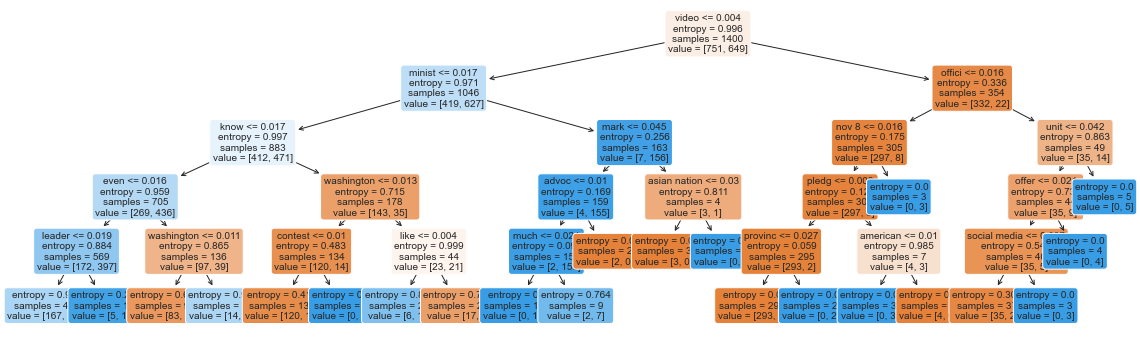

In [141]:

##### Cambio X_train_dense a X_train, por no dejar usar to_dense a un df en anotación anterior celda logistca.

plt.figure(figsize=(20,6))
tree.plot_tree(my_tree,feature_names = customized_vectorizer.get_feature_names(),filled=True,rounded=True, fontsize = 10)
plt.show()

## Boosting de Modelos

In [71]:
base_classifier = ExtraTreesClassifier(n_estimators=100, 
                                      criterion='gini', 
                                      max_depth = 4, 
                                      bootstrap=True, 
                                      n_jobs = -1, 
                                      random_state = 127,
                                      max_samples= 0.3)

boost_tree = AdaBoostClassifier(base_estimator = base_classifier, 
                            n_estimators = 200,
                            learning_rate = 0.8,                                       
                            random_state = 127)

boost_tree.fit(X_train, y_train) 
boost_tree.score(X_test, y_test)

0.9716666666666667

Text(0.5, 12.5, 'Etiquetas predichas')

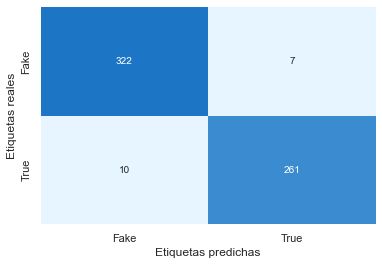

In [72]:
cm_boost_tree = confusion_matrix(y_test, boost_tree.predict(X_test))
sns.heatmap(cm_boost_tree, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

## Pipeline

In [81]:
testing_sample_size = 1000 # Algunas operaciones se demoran mucho tiempo, tamaño pequeño es para agilizarlas

data_sample = data.sample(testing_sample_size)
X = data_sample['text']
y = data_sample['real']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


In [105]:
pasos = [('vectorizador', CountVectorizer(lowercase = True, 
                                            strip_accents='unicode',
                                          tokenizer = porter_tokenizer)), 
         ('tfidf', TfidfTransformer()), 
         ('cambio_base', TruncatedSVD(n_components = n_components_90)),
         ('modelo', LogisticRegression())]
pipeline = Pipeline(pasos)

In [106]:
param_grid = [{'vectorizador__ngram_range': [(1, 4)],
               'vectorizador__min_df': [0.01] ,#np.arange(0.01,0.11,0.02),
               'vectorizador__max_df': [0.8 ], #np.arange(0.8,1,0.05) ,
               'tfidf__norm': ['l1',
                #'l2'
                ],
               'cambio_base': [TruncatedSVD()
               #,None
                ],
               'cambio_base__n_components': [n_components_10
               #, n_components_50,n_components_90
               ],
               'modelo': [
                LogisticRegression()
                #,  ExtraTreesClassifier()
                ]}]

In [107]:
# Apróximadamente toma 10 min la ejecución con un sample de 1000 records y param_grid2
folds=StratifiedKFold(n_splits=5,shuffle=True)
grid = GridSearchCV(estimator = pipeline,param_grid = param_grid, cv = folds)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('vectorizador',
                                        CountVectorizer(strip_accents='unicode',
                                                        tokenizer=<function porter_tokenizer at 0x000001E7DE917F70>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('cambio_base',
                                        TruncatedSVD(n_components=1008)),
                                       ('modelo', LogisticRegression())]),
             param_grid=[{'cambio_base': [TruncatedSVD(n_components=23)],
                          'cambio_base__n_components': [23],
                          'modelo': [LogisticRegression()],
                          'tfidf__norm': ['l1'], 'vectorizador__max_df': [0.8],
                          'vectorizador__min_df': [0.01],
                          'vectorizador__ngram_range': [(1, 4)]}])

In [108]:
grid.best_score_

0.6942857142857142

In [109]:
grid.best_estimator_

Pipeline(steps=[('vectorizador',
                 CountVectorizer(max_df=0.8, min_df=0.01, ngram_range=(1, 4),
                                 strip_accents='unicode',
                                 tokenizer=<function porter_tokenizer at 0x000001E7DE917F70>)),
                ('tfidf', TfidfTransformer(norm='l1')),
                ('cambio_base', TruncatedSVD(n_components=23)),
                ('modelo', LogisticRegression())])

In [110]:
grid.best_params_

{'cambio_base': TruncatedSVD(n_components=23),
 'cambio_base__n_components': 23,
 'modelo': LogisticRegression(),
 'tfidf__norm': 'l1',
 'vectorizador__max_df': 0.8,
 'vectorizador__min_df': 0.01,
 'vectorizador__ngram_range': (1, 4)}

##### Grid Search Testing

              precision    recall  f1-score   support

        Fake       0.69      0.97      0.80       310
        True       0.94      0.52      0.67       290

    accuracy                           0.76       600
   macro avg       0.81      0.75      0.74       600
weighted avg       0.81      0.76      0.74       600



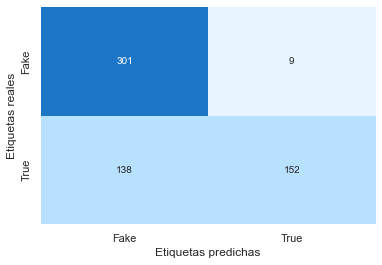

In [149]:
y_pred_grid = grid.predict(X_test)
"""confusion = confusion_matrix(y_test, y_pred_grid)
print(confusion)"""
confusion_grid = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(confusion_grid, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')
print (classification_report(y_test, y_pred_grid))

## Exportación de mejor modelo entrenado
Se realiza con pickle

In [150]:
# Escritura del modelo
with open('fakenews_model.pkl', 'wb') as f_model:
    pickle.dump(grid.best_estimator_, f_model)

In [151]:
# Lectura del modelo
with open('fakenews_model.pkl', 'rb') as f_model:
        fakenews_model = pickle.load(f_model)

              precision    recall  f1-score   support

        Fake       0.69      0.97      0.80       310
        True       0.94      0.52      0.67       290

    accuracy                           0.76       600
   macro avg       0.81      0.75      0.74       600
weighted avg       0.81      0.76      0.74       600



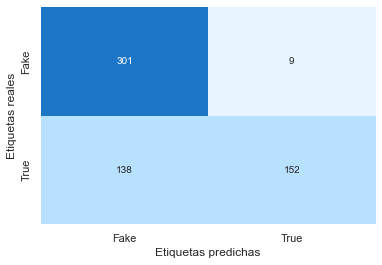

In [152]:
y_pred_grid = fakenews_model.predict(X_test)
"""confusion = confusion_matrix(y_test, y_pred_grid)
print(confusion)"""
confusion_grid = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(confusion_grid, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')
print (classification_report(y_test, y_pred_grid))

## Pipeline con título de las noticias (SIN contenido del texto)

In [153]:
# Hacer el pipeline sólamente con los títulos de las noticias para ver qué pasa

## A traves de webscraping se buscan noticias para obtener más datos de testing

In [156]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome(service=Service(ChromeDriverManager().install()),options=chrome_options)

def get_text_from_url_bbc(url):
    wd.get(url)

    time.sleep(1)

    soup = BeautifulSoup(wd.page_source)
    text = soup.find_all('div', {'data-component': 'text-block'}) #(?P<text>\>(.*?)\<)
    text = reversed(text) 
    text2 = ""
    for i in text:
        try:
            text2 = i.text+text2
        except:
            text2 = ""+text2
    return text2    

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [C:\Users\Usuario\.wdm\drivers\chromedriver\win32\102.0.5005.61\chromedriver.exe] found in cache


In [157]:

warnings.filterwarnings("ignore")
#https://newsapi.org/docs
response = requests.get("https://newsapi.org/v2/top-headlines?sources=bbc-news&apiKey=1f83e742c8804de0a5d427510829f79b")

list_urls = []
for i in range(0,len(response.json()['articles'])):
    list_urls.append(response.json()['articles'][i]['url'])  
    
list_texts = []
for i in range(0,len(list_urls)):
    list_texts.append(get_text_from_url_bbc(list_urls[i]))

In [162]:
def clean_review(review_text, tokenizer, stemmer, stopwords):    
    
    #tokens (eliminamos todos los signos de puntuación)
    words = tokenizer.tokenize(review_text)
    
    # stemming: raiz y minúsculas:
    stem_words = [stemmer.stem(x) for x in words]
    
    # eliminamos stopwords (ya pasaron por stem)
    clean_words = [x for x in stem_words if x not in stopwords]
    
    result = " ".join(clean_words)
    
    return(result)

In [163]:
data_texts_text = pd.DataFrame(list_texts, columns=['text'])
data_texts_text['len'] = data_texts_text.text.apply(lambda x: len(x))
data_texts_text['real'] = 'True'
data_texts_text = data_texts_text[data_texts_text.len>0]
#clean_texts_test = data_texts_text.text.progress_apply(lambda x: porter_tokenizer(x))

X_test_sparse_texts = customized_vectorizer.transform(clean_texts_test)
X_test_texts = pd.DataFrame(X_test_sparse_texts.todense(), 
             columns = customized_vectorizer.get_feature_names()) 
X_test_svd_texts = svd.transform(X_test_texts)
"""X_test_bigram_sparse_texts = count_vectorizer_bigram.transform(clean_texts_test)"""

AttributeError: 'Series' object has no attribute 'progress_apply'

In [ ]:
data_texts_text['predict_reg_base'] = reg_model.predict(X_test_texts)
data_texts_text['predict_prob_reg_base'] = reg_model.predict_proba(X_test_texts).T[0]

data_texts_text['predict_svd'] = reg_model_svd.predict(X_test_svd_texts)
data_texts_text['predict_prob_svd'] = reg_model_svd.predict_proba(X_test_svd_texts).T[0]

"""data_texts_text['predict_bigram'] = reg_model_bigram.predict(X_test_bigram_sparse_texts)
data_texts_text['predict_prob_bigram'] = reg_model_bigram.predict_proba(X_test_bigram_sparse_texts).T[0]
"""
data_texts_text['predict_my_tree'] = my_tree.predict(X_test_texts)
data_texts_text['predict_prob_my_tree'] = my_tree.predict_proba(X_test_texts).T[0]

data_texts_text

In [ ]:
X_train_explainer = np.array(X_train)
explainer = LimeTabularExplainer(X_train_explainer, 
                                 mode = "classification",
                                 training_labels = y_train,
                                 feature_names = X_train.columns,
                                 discretize_continuous=False)

#i = 13
#data_row = np.array(X_test.iloc[i])
data_row = np.array(X_test_texts.iloc[4])
explanation = explainer.explain_instance(data_row, reg_model.predict_proba, num_features=10)
explanation.as_pyplot_figure();

In [ ]:
data_texts_text.text.iloc[4]